# Plot validation between SUNTANS and IMOS data

In [27]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xray
from datetime import datetime
import pandas as pd
import os

import soda.utils.mysignal as sp
from soda.utils.timeseries import timeseries
from soda.dataio.suntans.sunprofile import Profile
from soda.utils.maptools import ll2utm
from soda.utils.modvsobs import ModVsObs
from soda.dataio import netcdfio
import soda.dataio as io
from soda.utils.myproj import MyProj


#from octant.tools import isoslice
from mycurrents import oceanmooring as om

from matplotlib import rcParams

#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "14"
rcParams['axes.labelsize']='large'

#%matplotlib notebook

In [28]:
# IMOS station file
Tfile = '/group/pawsey0106/mrayson/DATA/FIELD/IMOS/IMOS_Gridded_Mooring_T_QC.nc'

# SUNTANS profile netcdf file
sunfile = '../SCENARIOS/OUTPUT_NWS_2km_hex_2013_2014/NWS_2km_hex_2013_2014_Profile.nc'


In [29]:
def get_suntans_mo(X,Y, Uobs, sunTS, sunvar, units):
    """
    Get the suntans evuivalent points
    """
    Umod_xray = sunTS(X, Y, -Uobs.Z, sunvar, zinterp='nearest')
    # Convert SUNTANS timeseries to an ocean mooring object
    Umod = om.OceanMooring(Umod_xray.time.values, Umod_xray.values.squeeze(),\
        Uobs.Z, zinterp='linear')

    return ModVsObs(Umod.t, Umod.y, Uobs.t, Uobs.y, \
            Z=Uobs.Z, units=units, varname=sunvar), Umod

def compare_imos_suntans_temp(sunfile, Tfile, stationT, plot=True):
    print(72*'#')
    print('#\t Station: %s'%stationT)
    #print 'Loading the suntans profile...'
    sunTS = Profile(sunfile)
    sunTS
    ##########
    # Load the 400 and 200 m velocity and temperature data
    ##########
    #print 'Loading mooring data...'

    Tobs = om.from_netcdf(Tfile, 'watertemp', group=stationT)
    #Tobs.X, Tobs.Y
    
    # Set the project
    P = MyProj('merc')
    xstation, ystation = P.to_xy(Tobs.X,Tobs.Y)
    #xstation, ystation
    
    #print 'Grabbing suntans points...'
    mo_T, Umod = get_suntans_mo(xstation, ystation, Tobs, sunTS, 'temp', 'degC')
    
    if plot:
        mo_T.printStatsZ()

        # Filter and  Convert to oceanmooring objects
        dsobs = om.OceanMooring(mo_T.TSobs.t, mo_T.TSobs.filt_uneven(34*3600.,order=3), -mo_T.TSobs.Z, positive='down')
        dsmod = om.OceanMooring(mo_T.TSmod.t, mo_T.TSmod.filt_uneven(34*3600.,order=3), -mo_T.TSmod.Z, positive='down')
        ####
        # Plot
        plt.figure(figsize=(8,9))
        ax1=plt.subplot2grid((3,3),(0,0),colspan=3)
        dsobs.contourf(np.arange(7,32,1))
        plt.ylabel('Depth')
        ax1.set_xticklabels([])

        ax2=plt.subplot2grid((3,3),(1,0),colspan=3)
        dsmod.contourf(np.arange(7,32,1))
        plt.ylabel('Depth [m]')


        # Mean temp
        ax3=plt.subplot2grid((3,3),(2,0),colspan=1)
        plt.plot(mo_T.meanMod, mo_T.Z,'ro')
        plt.plot(mo_T.meanObs, mo_T.Z,'bo')
        plt.xlabel('Temperature [$^{\circ}$C]')
        plt.ylabel('Depth [m]')
        plt.grid(b=True)
        plt.xlim([7,30])
        plt.legend(('Mod.','Obs.'), loc='upper left')

        # Bias
        ax4=plt.subplot2grid((3,3),(2,1),colspan=1)
        plt.plot(mo_T.bias, mo_T.Z,'ko')
        plt.xlim(-2.25,2.25)
        ax4.set_xticks([-2,-1,0,1,2])
        ax4.set_yticklabels([])
        plt.xlabel('Bias [$^{\circ}$C]')
        plt.grid(b=True)


        # RMSE
        ax5=plt.subplot2grid((3,3),(2,2),colspan=1)
        plt.plot(mo_T.rmse, mo_T.Z,'ko')
        plt.xlim(-3,3)
        ax5.set_yticklabels([])
        plt.xlabel('RMSE [$^{\circ}$C]')
        plt.grid(b=True)

        plt.tight_layout()
        
        plt.savefig('../FIGURES/IMOS_v_SUNTANS_%s.png'%stationT, dpi=150)
        plt.show()
    
    return mo_T, Umod


########################################################################
#	 Station: PIL200_2013_b
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| -27.0 [m] | 27.278 | 26.278 |  1.448 |  1.181 |  1.169 |  0.913 |  0.019 | 
| -46.0 [m] | 27.148 | 25.807 |  1.379 |  1.002 |  1.593 |  0.783 | -1.530 | 
| -56.0 [m] | 27.029 | 25.469 |  1.314 |  0.919 |  1.851 |  0.653 | -3.060 | 
| -66.0 [m] | 26.861 | 25.122 |  1.222 |  0.886 |  2.041 |  0.525 | -4.300 | 
| -76.0 [m] | 26.632 | 24.748 |  1.100 |  0.904 |  2.173 |  0.431 | -4.775 | 
| -86.0 [m] | 26.327 | 24.336 |  0.973 |  0.919 |  2.247 |  0.394 | -4.986 | 
| -96.0 [m] | 25.933 | 23.910 |  0.879 |  0.938 |  2.251 |  0.412 | -4.760 | 
| -106.0 [m] | 25.456 | 23.381 |  0.881 |  0.971 |  2.291 |  0.453 | -4.570 | 
| -126.0 [m] | 24.235 | 22.493 |  1.199 |  1.050 |  2.102 |  0.459 | -3.005 | 
| -136.0 [m] | 23.498 | 22.000 |  1.4

/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


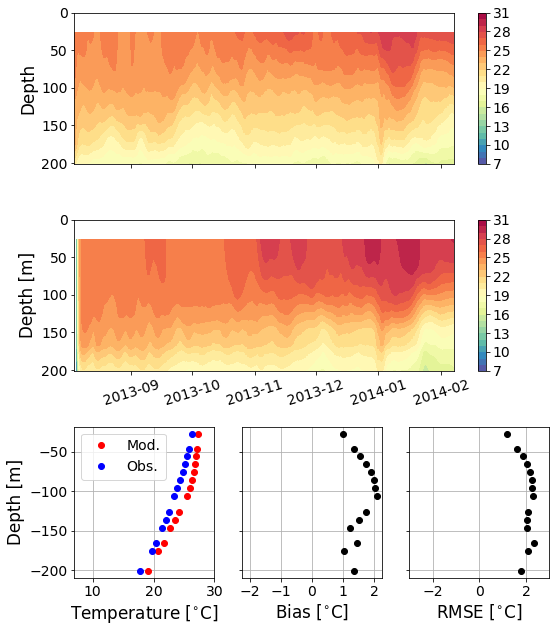

(<soda.utils.modvsobs.ModVsObs at 0x2ae3c51cf080>,
 OceanMooring(Nz=14, Nt=42651)
 	variable:  [])

In [30]:
compare_imos_suntans_temp(sunfile, Tfile, 'PIL200_2013_b')

########################################################################
#	 Station: PIL200_2014_a
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| -29.0 [m] | 29.837 | 28.744 |  1.007 |  1.102 |  1.218 |  0.874 | -0.221 | 
| -38.0 [m] | 29.812 | 28.456 |  0.992 |  1.026 |  1.528 |  0.757 | -1.219 | 
| -48.0 [m] | 29.745 | 27.965 |  0.965 |  1.036 |  2.033 |  0.520 | -2.853 | 
| -58.0 [m] | 29.277 | 27.337 |  0.953 |  1.132 |  2.225 |  0.466 | -2.859 | 
| -68.0 [m] | 28.789 | 26.618 |  1.044 |  1.212 |  2.458 |  0.487 | -3.110 | 
| -78.0 [m] | 28.089 | 25.905 |  1.195 |  1.249 |  2.463 |  0.567 | -2.886 | 
| -88.0 [m] | 27.177 | 25.201 |  1.343 |  1.288 |  2.254 |  0.660 | -2.063 | 
| -98.0 [m] | 26.113 | 24.483 |  1.469 |  1.333 |  1.926 |  0.736 | -1.086 | 
| -109.0 [m] | 24.985 | 23.775 |  1.584 |  1.378 |  1.568 |  0.782 | -0.294 | 
| -118.0 [m] | 24.985 | 23.182 |  1.58

/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


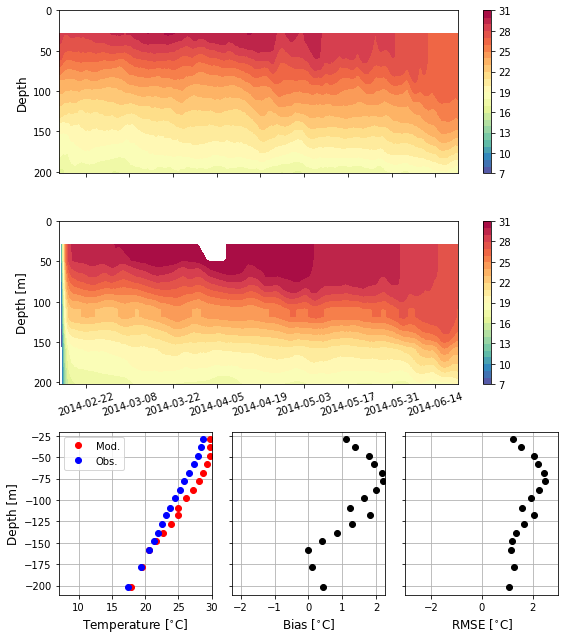

(<soda.utils.modvsobs.ModVsObs at 0x2ae3c4df5c18>,
 OceanMooring(Nz=16, Nt=42651)
 	variable:  [])

In [10]:
compare_imos_suntans_temp(sunfile, Tfile, 'PIL200_2014_a')

########################################################################
#	 Station: KIM100_2013_b
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| -24.7 [m] | 28.419 | 27.833 |  1.030 |  1.246 |  0.890 |  0.833 |  0.489 | 
| -29.7 [m] | 28.419 | 27.688 |  1.030 |  1.215 |  1.028 |  0.794 |  0.283 | 
| -39.7 [m] | 28.293 | 27.268 |  1.005 |  1.104 |  1.362 |  0.642 | -0.522 | 
| -49.7 [m] | 27.833 | 26.748 |  0.922 |  0.984 |  1.503 |  0.391 | -1.336 | 
| -59.7 [m] | 27.475 | 26.220 |  0.899 |  0.914 |  1.695 |  0.211 | -2.438 | 
| -79.7 [m] | 26.487 | 25.080 |  1.030 |  0.957 |  1.861 |  0.238 | -2.796 | 
| -84.7 [m] | 26.487 | 24.805 |  1.030 |  1.007 |  2.095 |  0.249 | -3.328 | 
| -94.7 [m] | 25.791 | 24.019 |  1.190 |  1.184 |  2.155 |  0.458 | -2.324 | 



/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


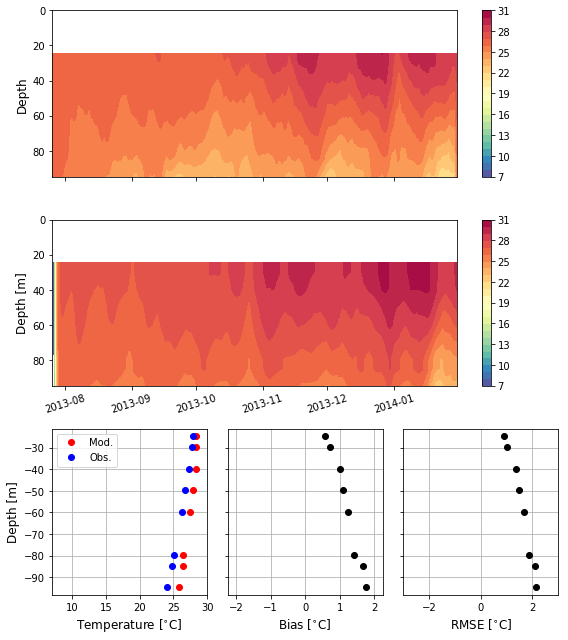

(<soda.utils.modvsobs.ModVsObs at 0x2ae3c5016588>, OceanMooring(Nz=8, Nt=42651)
 	variable:  [])

In [11]:
compare_imos_suntans_temp(sunfile, Tfile, 'KIM100_2013_b')

########################################################################
#	 Station: KIM100_2014_a
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| -24.0 [m] | 29.543 | 29.112 |  0.815 |  1.020 |  0.999 |  0.537 |  0.042 | 
| -29.0 [m] | 29.543 | 28.914 |  0.815 |  1.110 |  1.186 |  0.489 | -0.142 | 
| -39.0 [m] | 29.354 | 28.349 |  0.862 |  1.287 |  1.574 |  0.421 | -0.495 | 
| -49.0 [m] | 28.719 | 27.620 |  1.031 |  1.479 |  1.778 |  0.426 | -0.444 | 
| -79.0 [m] | 27.002 | 25.349 |  1.372 |  1.667 |  2.094 |  0.658 | -0.578 | 
| -84.0 [m] | 27.002 | 24.971 |  1.372 |  1.584 |  2.352 |  0.687 | -1.205 | 
| -94.0 [m] | 26.198 | 24.241 |  1.527 |  1.454 |  2.236 |  0.738 | -1.366 | 



/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


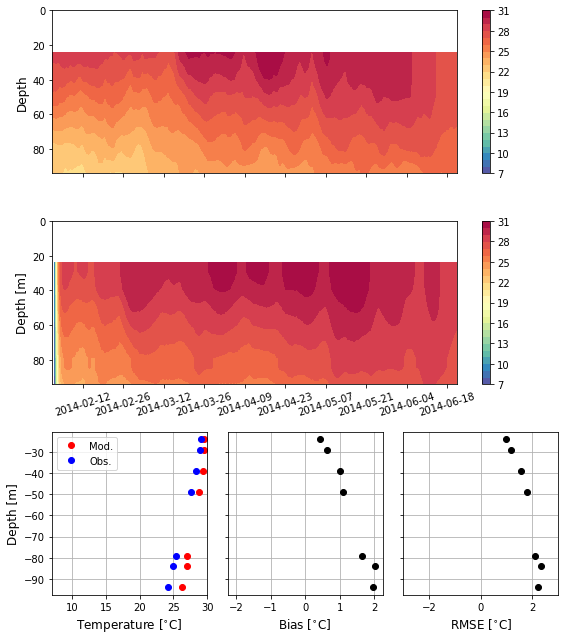

(<soda.utils.modvsobs.ModVsObs at 0x2ae3c4e97198>, OceanMooring(Nz=7, Nt=42651)
 	variable:  [])

In [12]:
compare_imos_suntans_temp(sunfile, Tfile, 'KIM100_2014_a')

########################################################################
#	 Station: KIM200_2013_b
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| -30.3 [m] | 28.647 | 27.855 |  1.037 |  1.195 |  0.997 |  0.862 |  0.304 | 
| -38.3 [m] | 28.563 | 27.593 |  1.005 |  1.118 |  1.202 |  0.782 | -0.156 | 
| -48.3 [m] | 28.394 | 27.131 |  0.938 |  1.004 |  1.529 |  0.607 | -1.320 | 
| -58.3 [m] | 27.739 | 26.617 |  0.785 |  0.887 |  1.440 |  0.421 | -1.637 | 
| -68.3 [m] | 27.275 | 26.132 |  0.795 |  0.849 |  1.474 |  0.362 | -2.013 | 
| -78.3 [m] | 26.722 | 25.624 |  0.890 |  0.899 |  1.456 |  0.430 | -1.624 | 
| -88.3 [m] | 26.105 | 25.097 |  1.035 |  0.984 |  1.409 |  0.525 | -1.050 | 
| -98.3 [m] | 25.408 | 24.504 |  1.180 |  1.065 |  1.345 |  0.610 | -0.594 | 
| -108.3 [m] | 25.408 | 23.890 |  1.180 |  1.138 |  1.816 |  0.630 | -1.545 | 
| -118.3 [m] | 24.636 | 23.244 |  1.30

/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


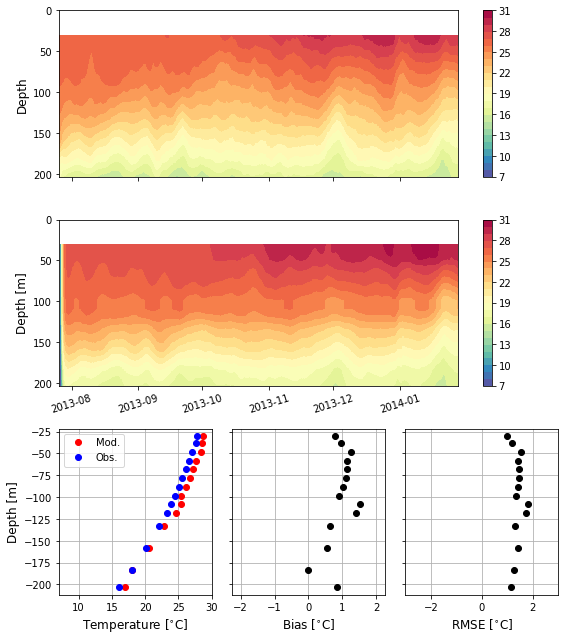

(<soda.utils.modvsobs.ModVsObs at 0x2ae3c51b8cf8>,
 OceanMooring(Nz=14, Nt=42651)
 	variable:  [])

In [13]:
compare_imos_suntans_temp(sunfile, Tfile, 'KIM200_2013_b')

########################################################################
#	 Station: KIM200_2014_a
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| -30.0 [m] | 29.817 | 28.812 |  0.773 |  1.192 |  1.479 |  0.456 | -0.540 | 
| -38.0 [m] | 29.662 | 28.423 |  0.827 |  1.361 |  1.749 |  0.450 | -0.651 | 
| -48.0 [m] | 29.401 | 27.755 |  0.941 |  1.559 |  2.147 |  0.483 | -0.895 | 
| -68.0 [m] | 27.911 | 26.379 |  1.386 |  1.739 |  2.042 |  0.649 | -0.378 | 
| -78.0 [m] | 27.190 | 25.699 |  1.465 |  1.756 |  1.971 |  0.693 | -0.261 | 
| -88.0 [m] | 26.374 | 25.053 |  1.503 |  1.701 |  1.779 |  0.730 | -0.094 | 
| -98.0 [m] | 25.472 | 24.419 |  1.509 |  1.624 |  1.536 |  0.747 |  0.105 | 
| -108.0 [m] | 25.472 | 23.795 |  1.509 |  1.533 |  1.983 |  0.758 | -0.675 | 
| -118.0 [m] | 24.493 | 23.148 |  1.497 |  1.454 |  1.698 |  0.753 | -0.365 | 
| -133.0 [m] | 22.398 | 22.072 |  1.4

/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


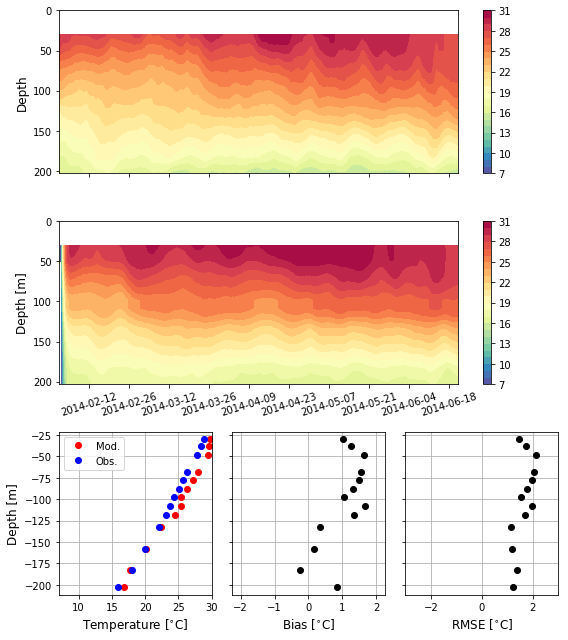

In [14]:
mo_T = compare_imos_suntans_temp(sunfile, Tfile, 'KIM200_2014_a')

########################################################################
#	 Station: KIM400_2013_b
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| -42.2 [m] | 28.731 | 27.811 |  1.037 |  1.068 |  1.112 |  0.824 | -0.086 | 
| -52.2 [m] | 28.543 | 27.429 |  0.922 |  0.922 |  1.361 |  0.641 | -1.179 | 
| -62.2 [m] | 28.233 | 26.938 |  0.739 |  0.737 |  1.566 |  0.287 | -3.512 | 
| -82.2 [m] | 27.292 | 25.955 |  0.630 |  0.711 |  1.596 |  0.159 | -4.037 | 
| -102.2 [m] | 26.014 | 24.818 |  1.142 |  1.033 |  1.552 |  0.590 | -1.257 | 
| -137.2 [m] | 23.108 | 22.140 |  1.337 |  1.197 |  1.438 |  0.653 | -0.443 | 
| -162.2 [m] | 20.685 | 20.104 |  1.013 |  1.094 |  1.119 |  0.591 | -0.046 | 
| -187.2 [m] | 18.183 | 18.031 |  0.775 |  0.974 |  1.015 |  0.359 | -0.087 | 
| -212.2 [m] | 15.819 | 16.161 |  0.750 |  0.869 |  1.149 |  0.089 | -0.747 | 
| -237.2 [m] | 14.740 | 14.666 |  

/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


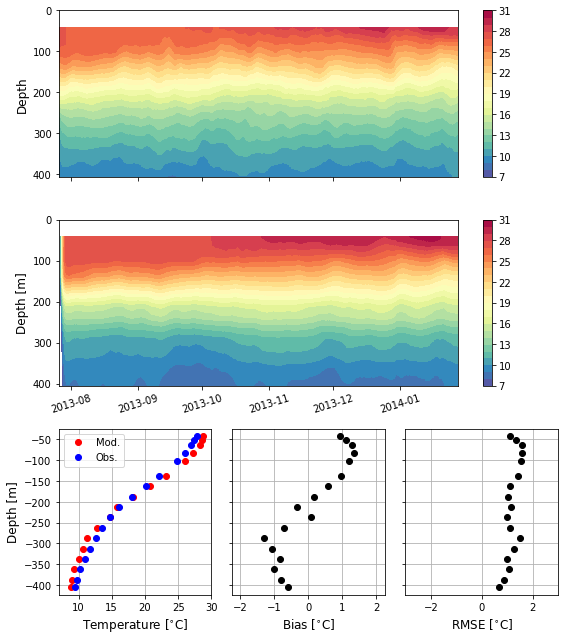

In [15]:
mo_T = compare_imos_suntans_temp(sunfile, Tfile, 'KIM400_2013_b')

########################################################################
#	 Station: KIM400_2014_a
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| -33.2 [m] | 29.987 | 29.455 |  0.706 |  0.999 |  1.002 |  0.549 | -0.007 | 
| -43.2 [m] | 29.838 | 29.057 |  0.699 |  1.165 |  1.317 |  0.443 | -0.279 | 
| -53.2 [m] | 29.574 | 28.458 |  0.756 |  1.412 |  1.710 |  0.416 | -0.467 | 
| -63.2 [m] | 29.132 | 27.652 |  0.891 |  1.638 |  2.102 |  0.428 | -0.646 | 
| -73.2 [m] | 28.462 | 26.772 |  1.017 |  1.713 |  2.280 |  0.467 | -0.771 | 
| -93.2 [m] | 26.581 | 25.048 |  1.107 |  1.601 |  2.074 |  0.519 | -0.679 | 
| -103.2 [m] | 25.473 | 24.178 |  1.077 |  1.430 |  1.851 |  0.474 | -0.674 | 
| -113.2 [m] | 24.305 | 23.364 |  0.990 |  1.274 |  1.557 |  0.422 | -0.495 | 
| -138.2 [m] | 21.965 | 21.508 |  0.843 |  1.094 |  1.203 |  0.362 | -0.210 | 
| -163.2 [m] | 19.767 | 19.614 |  0.

/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


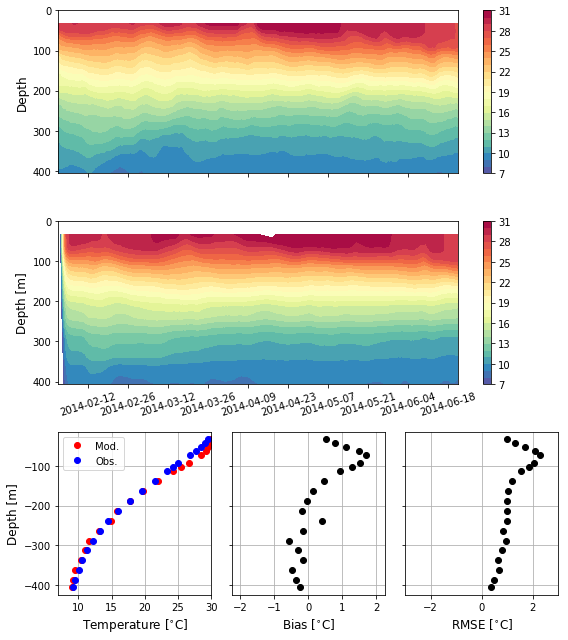

In [16]:
mo_T = compare_imos_suntans_temp(sunfile, Tfile, 'KIM400_2014_a')

########################################################################
#	 Station: ITFTIS_2013_b
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| -29.0 [m] | 28.294 | 27.711 |  1.134 |  1.179 |  1.032 |  0.728 |  0.234 | 
| -39.0 [m] | 28.263 | 27.357 |  1.113 |  0.991 |  1.328 |  0.574 | -0.797 | 
| -49.0 [m] | 27.929 | 27.004 |  0.896 |  0.889 |  1.399 |  0.309 | -1.474 | 
| -59.0 [m] | 27.624 | 26.655 |  0.744 |  0.867 |  1.439 |  0.133 | -1.762 | 
| -69.0 [m] | 27.250 | 26.320 |  0.653 |  1.037 |  1.460 |  0.171 | -0.987 | 
| -79.0 [m] | 26.781 | 25.890 |  0.721 |  1.282 |  1.500 |  0.381 | -0.371 | 
| -99.0 [m] | 25.256 | 24.468 |  1.070 |  1.721 |  1.596 |  0.590 |  0.138 | 
| -114.0 [m] | 24.175 | 22.772 |  1.151 |  1.721 |  1.921 |  0.636 | -0.256 | 
| -129.0 [m] | 22.976 | 21.101 |  1.153 |  1.534 |  2.230 |  0.612 | -1.136 | 
| -154.0 [m] | 20.431 | 18.697 |  1.0

/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


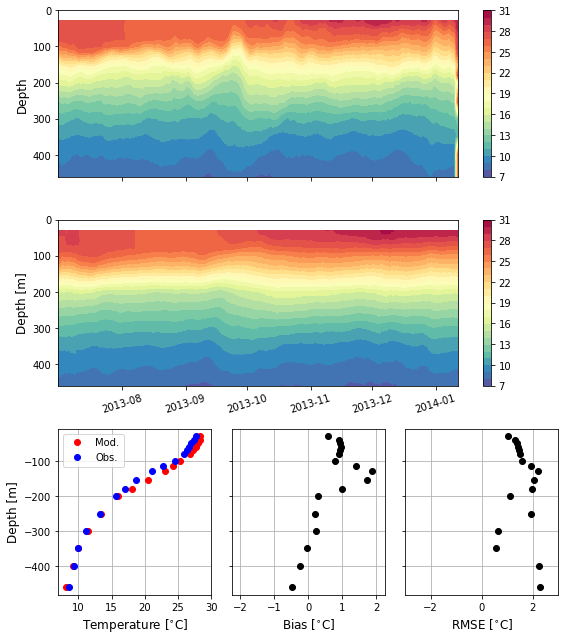

(<soda.utils.modvsobs.ModVsObs at 0x2ae3c4d6f240>,
 OceanMooring(Nz=17, Nt=42651)
 	variable:  [])

In [17]:
compare_imos_suntans_temp(sunfile, Tfile, 'ITFTIS_2013_b')

########################################################################
#	 Station: ITFTIS_2014_a
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| -17.5 [m] | 29.090 | 29.192 |  0.464 |  0.522 |  0.455 |  0.601 |  0.240 | 
| -27.0 [m] | 29.087 | 29.031 |  0.464 |  0.506 |  0.472 |  0.536 |  0.130 | 
| -37.0 [m] | 29.070 | 28.810 |  0.464 |  0.528 |  0.605 |  0.398 | -0.315 | 
| -47.0 [m] | 29.002 | 28.471 |  0.463 |  0.600 |  0.839 |  0.275 | -0.952 | 
| -57.0 [m] | 28.825 | 28.022 |  0.503 |  0.727 |  1.088 |  0.331 | -1.242 | 
| -67.0 [m] | 28.508 | 27.443 |  0.625 |  0.881 |  1.356 |  0.422 | -1.367 | 
| -77.0 [m] | 28.035 | 26.770 |  0.804 |  0.999 |  1.543 |  0.539 | -1.386 | 
| -97.0 [m] | 26.554 | 25.025 |  1.095 |  1.079 |  1.878 |  0.498 | -2.028 | 
| -112.0 [m] | 24.265 | 23.348 |  1.103 |  1.281 |  1.519 |  0.492 | -0.408 | 
| -127.0 [m] | 22.922 | 21.655 |  1.09

/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


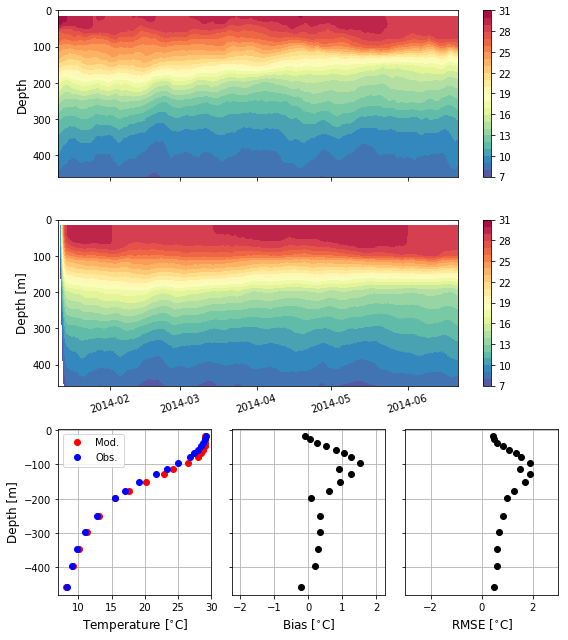

(<soda.utils.modvsobs.ModVsObs at 0x2ae3c5363a58>,
 OceanMooring(Nz=18, Nt=42651)
 	variable:  [])

In [18]:
compare_imos_suntans_temp(sunfile, Tfile, 'ITFTIS_2014_a')

########################################################################
#	 Station: ITFMHB_2013_b
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| -32.3 [m] | 28.936 | 28.273 |  1.028 |  0.875 |  0.825 |  0.879 |  0.110 | 
| -42.3 [m] | 28.882 | 27.902 |  0.996 |  0.577 |  1.168 |  0.797 | -3.096 | 
| -52.3 [m] | 28.783 | 27.639 |  0.947 |  0.379 |  1.364 |  0.661 | -12.010 | 
| -62.3 [m] | 28.671 | 27.468 |  0.897 |  0.282 |  1.442 |  0.478 | -25.189 | 
| -72.3 [m] | 28.548 | 27.344 |  0.831 |  0.261 |  1.449 |  0.248 | -29.794 | 
| -82.3 [m] | 28.404 | 27.231 |  0.737 |  0.266 |  1.412 | -0.011 | -27.174 | 
| -102.3 [m] | 28.132 | 26.983 |  0.503 |  0.399 |  1.374 | -0.387 | -10.869 | 
| -122.3 [m] | 27.993 | 26.542 |  0.444 |  0.735 |  1.785 | -0.526 | -4.897 | 
| -142.0 [m] | 27.886 | 25.921 |  0.705 |  0.948 |  2.439 | -0.516 | -5.619 | 



/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


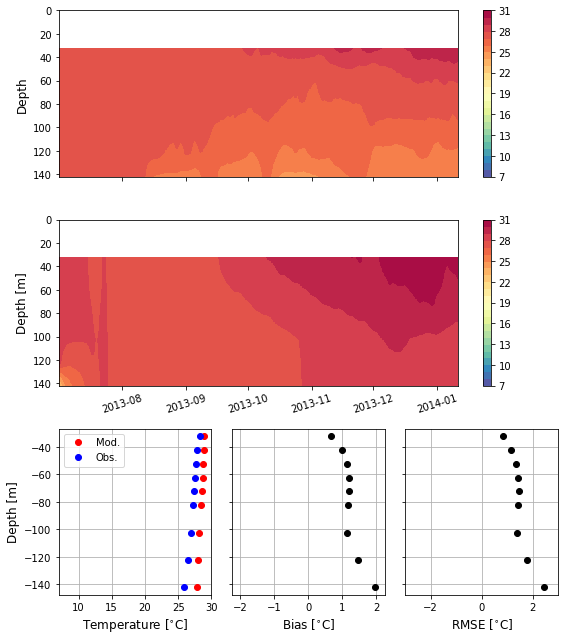

(<soda.utils.modvsobs.ModVsObs at 0x2ae3c5394358>, OceanMooring(Nz=9, Nt=42651)
 	variable:  [])

In [19]:
compare_imos_suntans_temp(sunfile, Tfile, 'ITFMHB_2013_b')

########################################################################
#	 Station: ITFMHB_2014_a
| Depth | Mean Model | Mean Obs. | Std. Mod. | Std Obs | RMSE |   CC   | skill |
|------| ---------- | --------- | --------- | ------- | --- | ----- | ------| 
| -22.1 [m] | 29.486 | 29.111 |  0.382 |  0.537 |  0.621 |  0.463 | -0.336 | 
| -37.8 [m] | 29.473 | 28.841 |  0.384 |  0.461 |  0.782 |  0.420 | -1.880 | 
| -57.9 [m] | 29.392 | 28.330 |  0.402 |  0.385 |  1.152 |  0.357 | -7.946 | 
| -77.8 [m] | 29.138 | 27.867 |  0.462 |  0.440 |  1.333 |  0.603 | -8.184 | 
| -87.8 [m] | 28.984 | 27.620 |  0.499 |  0.489 |  1.426 |  0.646 | -7.491 | 
| -97.8 [m] | 28.780 | 27.345 |  0.552 |  0.575 |  1.507 |  0.668 | -5.860 | 
| -107.8 [m] | 28.780 | 27.049 |  0.552 |  0.689 |  1.818 |  0.618 | -5.956 | 
| -117.8 [m] | 28.599 | 26.739 |  0.606 |  0.755 |  1.925 |  0.755 | -5.493 | 
| -127.8 [m] | 28.526 | 26.355 |  0.630 |  0.704 |  2.215 |  0.787 | -8.900 | 
| -141.5 [m] | 28.513 | 26.003 |  0.

/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


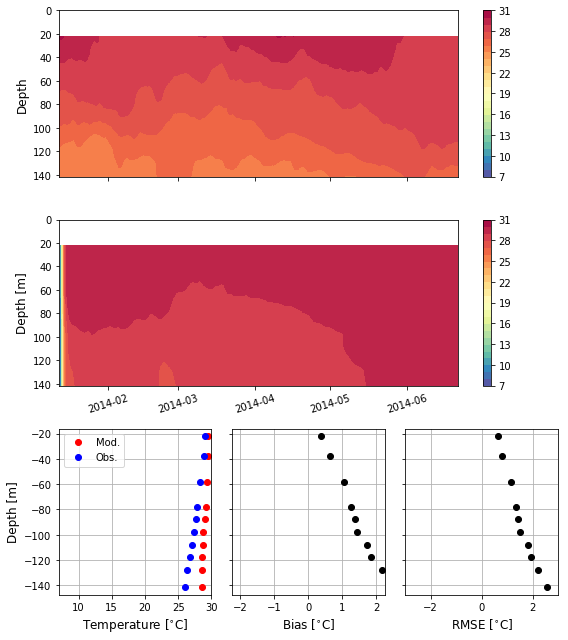

(<soda.utils.modvsobs.ModVsObs at 0x2ae3c4dac5c0>,
 OceanMooring(Nz=10, Nt=42651)
 	variable:  [])

In [20]:
compare_imos_suntans_temp(sunfile, Tfile, 'ITFMHB_2014_a')

# Plot some high frequency examples

In [21]:
mo_T, Tmod = compare_imos_suntans_temp(sunfile, Tfile, 'KIM400_2013_b', plot=False)

########################################################################
#	 Station: KIM400_2013_b


In [22]:
t1 = datetime(2013,10,1)
t2 = datetime(2013,11,1)
dsobs = om.OceanMooring(mo_T.TSobs.t, mo_T.TSobs.y, -mo_T.TSobs.Z, positive='down').clip(t1,t2)
dsmod = om.OceanMooring(mo_T.TSmod.t, mo_T.TSmod.y, -mo_T.TSmod.Z, positive='down').clip(t1,t2)

/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


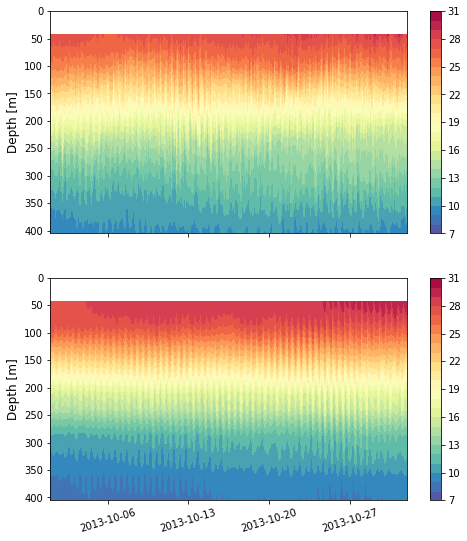

In [23]:
plt.figure(figsize=(8,9))
ax1=plt.subplot2grid((2,3),(0,0),colspan=3)
dsobs.contourf(np.arange(7,32,1))
plt.ylabel('Depth [m]')
ax1.set_xticklabels([])

ax2=plt.subplot2grid((2,3),(1,0),colspan=3)
dsmod.contourf(np.arange(7,32,1))
plt.ylabel('Depth [m]')

plt.show()

/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


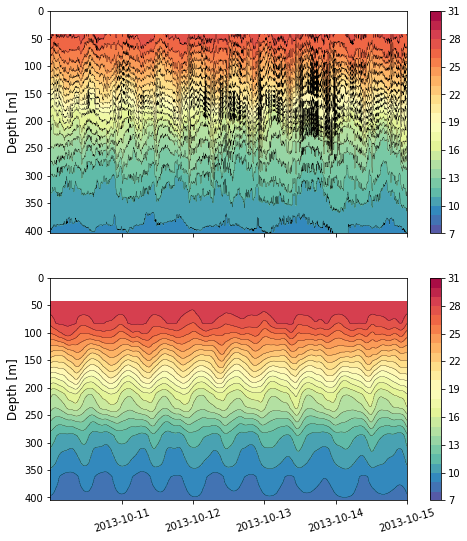

In [24]:
t1 = datetime(2013,10,10)
t2 = datetime(2013,10,15)
dsobs = om.OceanMooring(mo_T.TSobs.t, mo_T.TSobs.y, -mo_T.TSobs.Z, positive='down').clip(t1,t2)
dsmod = om.OceanMooring(mo_T.TSmod.t, mo_T.TSmod.y, -mo_T.TSmod.Z, positive='down').clip(t1,t2)

plt.figure(figsize=(8,9))
ax1=plt.subplot2grid((2,3),(0,0),colspan=3)
dsobs.contourf(np.arange(7,32,1))
dsobs.contourf(np.arange(7,32,1),filled=False,cbar=False)

plt.ylabel('Depth [m]')
ax1.set_xticklabels([])

ax2=plt.subplot2grid((2,3),(1,0),colspan=3)
dsmod.contourf(np.arange(7,32,1))
dsmod.contourf(np.arange(7,32,1),filled=False,cbar=False)

plt.ylabel('Depth [m]')

plt.show()

/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


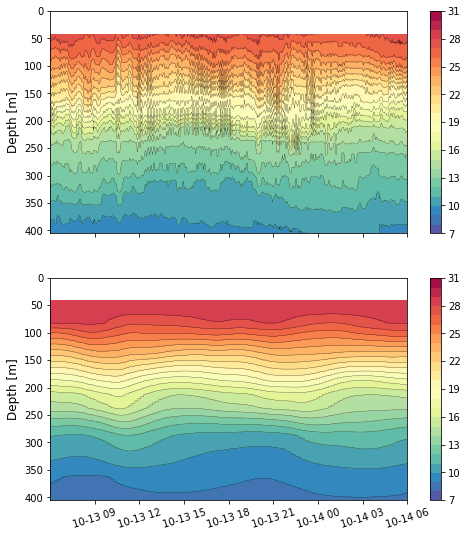

In [25]:
t1 = datetime(2013,10,13,6,0,0)
t2 = datetime(2013,10,14,6,0,0)
dsobs = om.OceanMooring(mo_T.TSobs.t, mo_T.TSobs.y, -mo_T.TSobs.Z, positive='down').clip(t1,t2)
dsmod = om.OceanMooring(mo_T.TSmod.t, mo_T.TSmod.y, -mo_T.TSmod.Z, positive='down').clip(t1,t2)

plt.figure(figsize=(8,9))
ax1=plt.subplot2grid((2,3),(0,0),colspan=3)
dsobs.contourf(np.arange(7,32,1))
dsobs.contourf(np.arange(7,32,1),filled=False,cbar=False)

plt.ylabel('Depth [m]')
ax1.set_xticklabels([])

ax2=plt.subplot2grid((2,3),(1,0),colspan=3)
dsmod.contourf(np.arange(7,32,1))
dsmod.contourf(np.arange(7,32,1),filled=False,cbar=False)

plt.ylabel('Depth [m]')

plt.show()

/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


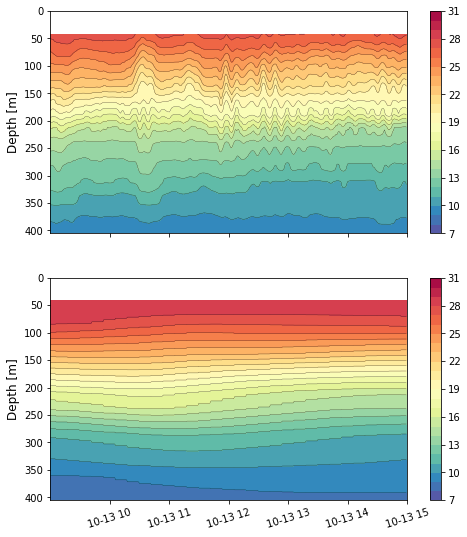

In [26]:
t1 = datetime(2013,10,13,9,0,0)
t2 = datetime(2013,10,13,15,0,0)
dsobs = om.OceanMooring(mo_T.TSobs.t, mo_T.TSobs.y, -mo_T.TSobs.Z, positive='down').clip(t1,t2)
dsmod = om.OceanMooring(mo_T.TSmod.t, mo_T.TSmod.y, -mo_T.TSmod.Z, positive='down').clip(t1,t2)

plt.figure(figsize=(8,9))
ax1=plt.subplot2grid((2,3),(0,0),colspan=3)
dsobs.contourf(np.arange(7,32,1))
dsobs.contourf(np.arange(7,32,1),filled=False,cbar=False)

plt.ylabel('Depth [m]')
ax1.set_xticklabels([])

ax2=plt.subplot2grid((2,3),(1,0),colspan=3)
dsmod.contourf(np.arange(7,32,1))
dsmod.contourf(np.arange(7,32,1),filled=False,cbar=False)

plt.ylabel('Depth [m]')

plt.show()